# 利用fbprophet预测新冠疫情期间的供水总量论文

**2020年3月1日prophet预测三月供水总量**

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
mpl.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime as dt

In [2]:

sup_water = pd.read_excel(r'~/mypyworks/自来水数据/2015-2020日供水总量.xlsx')

In [3]:
sup_water

,QUOTA_DATE,最低温度,最高温度,水厂供水总量
0,2015-01-01,15.0,21.0,3941482.0
1,2015-01-02,6.0,20.0,3903494.0
2,2015-01-03,13.0,21.0,4055444.0
3,2015-01-04,8.0,22.0,4077068.0
4,2015-01-05,16.0,23.0,4062857.0
...,...,...,...,...
1921,2020-04-05,15.0,17.0,3856963.0
1922,2020-04-06,14.0,15.0,3928905.0
1923,2020-04-07,14.0,21.0,4170486.0
1924,2020-04-08,16.0,25.0,4256246.0


In [4]:
#设置数据集
sup_water = sup_water.set_index('QUOTA_DATE').sort_index()['2015':]

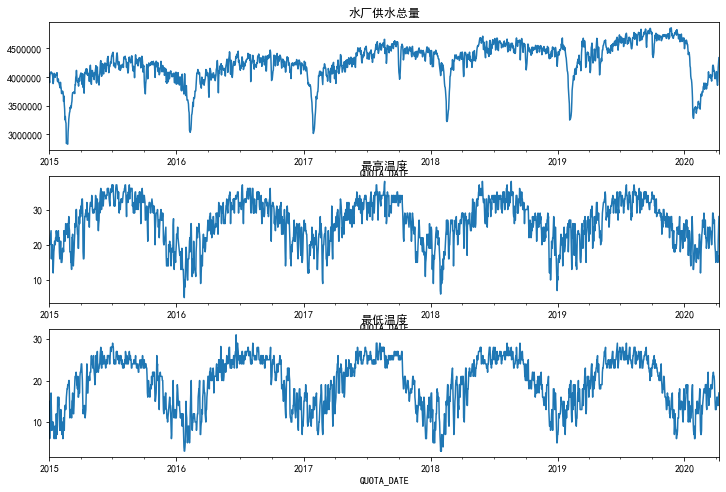

In [5]:
plt.figure(figsize=(12,8))
plt.subplot(311)
sup_water['水厂供水总量'].plot(title='水厂供水总量')
plt.subplot(312)
sup_water['最高温度'].plot(title='最高温度') 
plt.subplot(313)
sup_water['最低温度'].plot(title='最低温度')

In [6]:
#判断缺失值
# sup_water[sup_water.isnull().any(axis=1)]

# np.isinf(sup_water['最高温度']).value_counts()

#判断数据框里面所有不是有限数据的数，可以排除null，np.nan,np.inf
sup_water[~(np.isfinite(sup_water).all(axis=1))]

,最低温度,最高温度,水厂供水总量
QUOTA_DATE,,,


In [7]:
#判断离群值
# print(sup_water['最高温度'].value_counts(dropna=False))
am = sup_water['最高温度'].rolling(window=3,min_periods=0,center=True).mean()
diff = sup_water['最高温度'].values-am

# plt.figure(figsize=(12,8))
# plt.scatter(data = sup_water, x= sup_water.index.values,
#          y = '最低温度', 
#          marker='.',label='最低温度')
# plt.plot(sup_water.index.values,sup_water['上限'],'r--',label='离群上限')
# plt.plot(sup_water.index.values,sup_water['下限'],'r--',label='离群下限')
# plt.legend(loc='best')
# plt.title("动态判断时间序列的离群值")

sup_water.loc[diff.abs()>diff.std(ddof=0)*4,].sort_values('最高温度')

,最低温度,最高温度,水厂供水总量
QUOTA_DATE,,,
2018-03-08,10.0,14.0,4118609.0
2016-12-26,13.0,25.0,4247801.0
2017-03-23,19.0,31.0,4075998.0


In [8]:
sup_water.eval("平均温度=(最高温度+最低温度)/2",inplace=True)

In [9]:
sup_water

,最低温度,最高温度,水厂供水总量,平均温度
QUOTA_DATE,,,,
2015-01-01,15.0,21.0,3941482.0,18.0
2015-01-02,6.0,20.0,3903494.0,13.0
2015-01-03,13.0,21.0,4055444.0,17.0
2015-01-04,8.0,22.0,4077068.0,15.0
2015-01-05,16.0,23.0,4062857.0,19.5
...,...,...,...,...
2020-04-05,15.0,17.0,3856963.0,16.0
2020-04-06,14.0,15.0,3928905.0,14.5
2020-04-07,14.0,21.0,4170486.0,17.5


**按照多项式处理来看各指标的相关性**

In [10]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3,include_bias=1)
X_poly = poly_features.fit_transform(sup_water[['最低温度','最高温度','平均温度']])

#将poly数组转化程dataframe画相关矩阵，np也有相关矩阵函数，但带列名更加清楚。
sup_water_poly= pd.DataFrame(data=X_poly,columns=poly_features.get_feature_names())

sup_water_poly['水厂供水总量'] = sup_water['水厂供水总量'].values

sup_water_poly.corrwith(sup_water_poly['水厂供水总量']).sort_values(ascending=False)

水厂供水总量      1.000000
x1          0.481098
x1^2        0.480967
x1 x2       0.480365
x2^2        0.474747
x1^2 x2     0.474024
x1 x2^2     0.473195
x1^3        0.472337
x2          0.471655
x0 x1^2     0.471472
x2^3        0.470469
x0 x1       0.470306
x0 x1 x2    0.468311
x0 x2^2     0.463839
x0^2 x1     0.461419
x0 x2       0.461198
x0^2 x2     0.455720
x0^3        0.446535
x0^2        0.445867
x0          0.435845
1                NaN
dtype: float64

**从上面结果来看最高温的相关性最高**

In [ ]:
#pd还提供做相关矩阵和相关性图的函数，但因为指标太多，因此省去。
# sup_water.corr()
# pd.plotting.scatter_matrix(sup_water,figsize=(12,8),alpha=0.2)

## **正式运用模型**

In [11]:
sup_water_fp=sup_water.reset_index()[['QUOTA_DATE','水厂供水总量','最高温度']].rename(columns={'QUOTA_DATE':'ds','水厂供水总量':'y'})

In [12]:
# sup_water_fp['y'] = np.log(sup_water_fp['y'])

In [13]:
# cap = 5050000
# sup_water_fp['cap']= cap

In [14]:
# import borax

In [15]:
import sxtwl
lunar = sxtwl.Lunar()


In [16]:
guoqing = pd.DataFrame({
  'holiday': 'guoqing',
  'ds': pd.date_range(start= '2015-10-1',periods=6,freq='AS-OCT'),
  'lower_window': 0,
  'upper_window': 6,
})

spring_date=[]
for i in list(range(2014,2020)):
    solar_day = lunar.getDayByLunar(i,12,30)
    solar_date = dt.date(solar_day.y, solar_day.m, solar_day.d)
    spring_date.append(solar_date)
    
spring = pd.DataFrame({
  'holiday': 'spring',
  'ds':spring_date,
  'lower_window': -14,
  'upper_window': 14,
})

covid1 = pd.DataFrame({
  'holiday': 'covid1',
  'ds':pd.date_range(start= '2020-1-23',end='2020-2-23'),
  'lower_window': 0,
  'upper_window': 0,
})

covid2 = pd.DataFrame({
  'holiday': 'covid2',
  'ds':pd.date_range(start= '2020-2-24',end='2020-4-7'),
  'lower_window': 0,
  'upper_window': 0,
})

covid3 = pd.DataFrame({
  'holiday': 'covid3',
  'ds':pd.date_range(start= '2020-4-8',end='2020-4-30'),
  'lower_window': 0,
  'upper_window': 0,
})



holidays = pd.concat((guoqing, spring,covid1,covid2,covid3))

In [17]:
holidays

,holiday,ds,lower_window,upper_window
0,guoqing,2015-10-01 00:00:00,0,6
1,guoqing,2016-10-01 00:00:00,0,6
2,guoqing,2017-10-01 00:00:00,0,6
3,guoqing,2018-10-01 00:00:00,0,6
4,guoqing,2019-10-01 00:00:00,0,6
...,...,...,...,...
18,covid3,2020-04-26 00:00:00,0,0
19,covid3,2020-04-27 00:00:00,0,0
20,covid3,2020-04-28 00:00:00,0,0
21,covid3,2020-04-29 00:00:00,0,0


In [18]:
sup_water_fp

,ds,y,最高温度
0,2015-01-01,3941482.0,21.0
1,2015-01-02,3903494.0,20.0
2,2015-01-03,4055444.0,21.0
3,2015-01-04,4077068.0,22.0
4,2015-01-05,4062857.0,23.0
...,...,...,...
1921,2020-04-05,3856963.0,17.0
1922,2020-04-06,3928905.0,15.0
1923,2020-04-07,4170486.0,21.0
1924,2020-04-08,4256246.0,25.0


In [41]:
#initial=三（10=-1），period=7天，cv=10折，horizon=31天
7*(10-1)+365*2+31+1
# dt.date(2020,4,2)-dt.timedelta(days = 31)

825

In [20]:
sup_water_train = sup_water_fp[-825:]
# sup_water_test = sup_water_fp[-31:]

In [37]:
sup_water_train

,ds,y,最高温度
1101,2018-01-06,4181480.0,13.0
1102,2018-01-07,4189069.0,17.0
1103,2018-01-08,4207737.0,16.0
1104,2018-01-09,4183956.0,9.0
1105,2018-01-10,4378260.0,14.0
...,...,...,...
1921,2020-04-05,3856963.0,17.0
1922,2020-04-06,3928905.0,15.0
1923,2020-04-07,4170486.0,21.0
1924,2020-04-08,4256246.0,25.0


In [38]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
# from sklearn.metrics import mean_squared_error

In [44]:
np.round(np.linspace(1,10,2),0).astype('int')

array([ 1, 10])

In [49]:
holidays_scale = np.round(np.linspace(0.5,10,2),1)
weekly_scale = np.round(np.linspace(0.5,10,2),1)
yearly_order = np.round(np.linspace(1,10,2),0).astype('int')
yearly_scale = np.round(np.linspace(0.5,10,2),1)
regressor_scale = np.round(np.linspace(1,20,2),1)


import itertools
paramlist = list(itertools.product(holidays_scale,yearly_order,weekly_scale,yearly_scale,regressor_scale ))

In [50]:
import warnings
warnings.filterwarnings("ignore") 
def fun_rmse(df):
            return np.sqrt(np.mean(np.square(df['y']-df['yhat'])))
df1 = pd.DataFrame(columns=('param', 'rmse'))
i = 0
for param in paramlist:
    try:
        m = Prophet(holidays=holidays,
            n_changepoints = 25,
            changepoint_range = 0.8 ,
            changepoint_prior_scale = 0.05,
            holidays_prior_scale=param[0] )
        m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=param[1])
        m.add_seasonality(name='yearly', period=365.25, fourier_order=param[2], prior_scale=param[3])
        m.add_regressor('最高温度',prior_scale=param[4])
        m.fit(sup_water_train)

        df_cv = cross_validation(m, initial='730 days', period='7 days', horizon = '31 days') 
        rmse_ave = df_cv.groupby('cutoff').apply(fun_rmse).mean()
        df1.loc[i-1] = [param,rmse_ave]   
        i+=1
        print('第{:d}次记录完成'.format(i))
    except:
        continue
df1.sort_values(['rmse']).head(10)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第4次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第5次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第6次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第7次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第8次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第9次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第10次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第11次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第12次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第13次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第14次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第15次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第16次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第17次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第18次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第19次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第20次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第21次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第22次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第23次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第24次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第25次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第26次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第27次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第28次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第29次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第30次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第31次记录完成


INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-01-06 00:00:00 and 2020-03-09 00:00:00


第32次记录完成


,param,rmse
14,"(0.5, 10, 10.0, 10.0, 20.0)",310946.769915
12,"(0.5, 10, 10.0, 0.5, 20.0)",311015.067283
9,"(0.5, 10, 0.5, 10.0, 1.0)",311324.324746
27,"(10.0, 10, 10.0, 0.5, 1.0)",311977.472513
26,"(10.0, 10, 0.5, 10.0, 20.0)",312109.300538
30,"(10.0, 10, 10.0, 10.0, 20.0)",312364.780819
7,"(0.5, 10, 0.5, 0.5, 1.0)",312574.098089
25,"(10.0, 10, 0.5, 10.0, 1.0)",312603.533139
10,"(0.5, 10, 0.5, 10.0, 20.0)",312627.015206
29,"(10.0, 10, 10.0, 10.0, 1.0)",313571.413664


In [ ]:
#随机搜索
# import warnings
# warnings.filterwarnings("ignore") 
# def fun_rmse(df):
#             return np.sqrt(np.mean(np.square(df['y']-df['yhat'])))
# df1 = pd.DataFrame(columns=('param',  'rmse'))
# i = 0
# while i < 200:
#     i+=1
#     print('第{:d}次计算'.format(i))
#     try:
#         # 参数搜索
#         changepoint_range = 0.8 
#         changepoint_prior_scale = 0.05
#         holidays_prior_scale = round(np.random.uniform(0.1,10.1),1)
#         yearly_fourier_order = np.random.randint(1,11)
#         weekly_prior_scale = round(np.random.uniform(0.1,10.1),1)
#         yearly_prior_scale = round(np.random.uniform(0.1,10.1),1)
#         regressor_prior_scale = round(np.random.uniform(0.1,10.1),1)
#         param={'ch_range':changepoint_range,'ch_ps':changepoint_prior_scale,'holi_ps':holidays_prior_scale,
#                       'weekly_ps':weekly_prior_scale,'yearly_forder':yearly_fourier_order,'yearly_ps':yearly_prior_scale,
#                       'regressor_ps':regressor_prior_scale}
#         m = Prophet(holidays=holidays,
#             n_changepoints = 25,
#             changepoint_range=changepoint_range,
#             changepoint_prior_scale=changepoint_prior_scale,
#             holidays_prior_scale=holidays_prior_scale)
#         m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=weekly_prior_scale)
#         m.add_seasonality(name='yearly', period=365.25, fourier_order=yearly_fourier_order, prior_scale=yearly_prior_scale)
#         m.add_regressor('最高温度',prior_scale=regressor_prior_scale)
#         m.fit(sup_water_train)

#         df_cv = cross_validation(m, initial='1095 days', period='7 days', horizon = '31 days') 
#         rmse_ave = df_cv.groupby('cutoff').apply(fun_rmse).mean()
#         df1.loc[i-1] = [param,rmse_ave]                  
#     except:
#         continue

In [51]:
df1 = df1.sort_values(['rmse']).head(10)    
for param,rmse in zip(df1['param'],df1['rmse']):
    print(param,rmse)
# df1.to_excel('param.xls')

(0.5, 10, 10.0, 10.0, 20.0) 310946.76991540735
(0.5, 10, 10.0, 0.5, 20.0) 311015.0672834717
(0.5, 10, 0.5, 10.0, 1.0) 311324.3247456468
(10.0, 10, 10.0, 0.5, 1.0) 311977.4725130732
(10.0, 10, 0.5, 10.0, 20.0) 312109.30053840205
(10.0, 10, 10.0, 10.0, 20.0) 312364.7808193931
(0.5, 10, 0.5, 0.5, 1.0) 312574.09808893513
(10.0, 10, 0.5, 10.0, 1.0) 312603.5331393029
(0.5, 10, 0.5, 10.0, 20.0) 312627.01520597783
(10.0, 10, 10.0, 10.0, 1.0) 313571.4136641529


In [56]:
m = Prophet(holidays=holidays,
    n_changepoints = 25,
    changepoint_range = 0.8 ,
    changepoint_prior_scale = 0.05,
    holidays_prior_scale=0.5 )
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=10)
m.add_seasonality(name='yearly', period=365.25, fourier_order=10, prior_scale=10)
m.add_regressor('最高温度',prior_scale=20)
sup_water_train = sup_water_train[-730:]
m.fit(sup_water_train)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


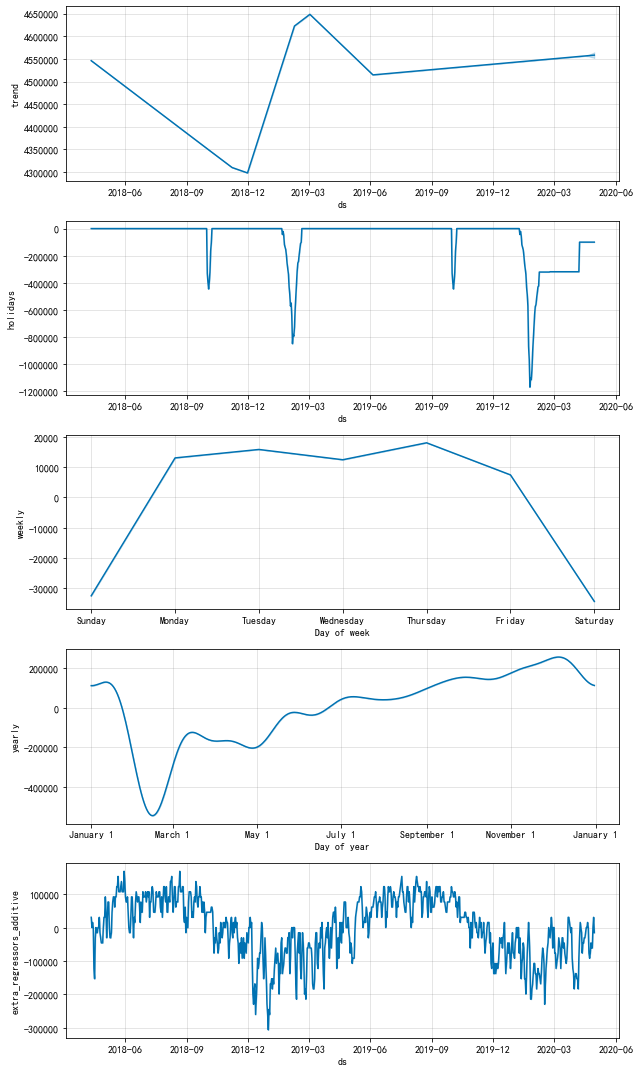

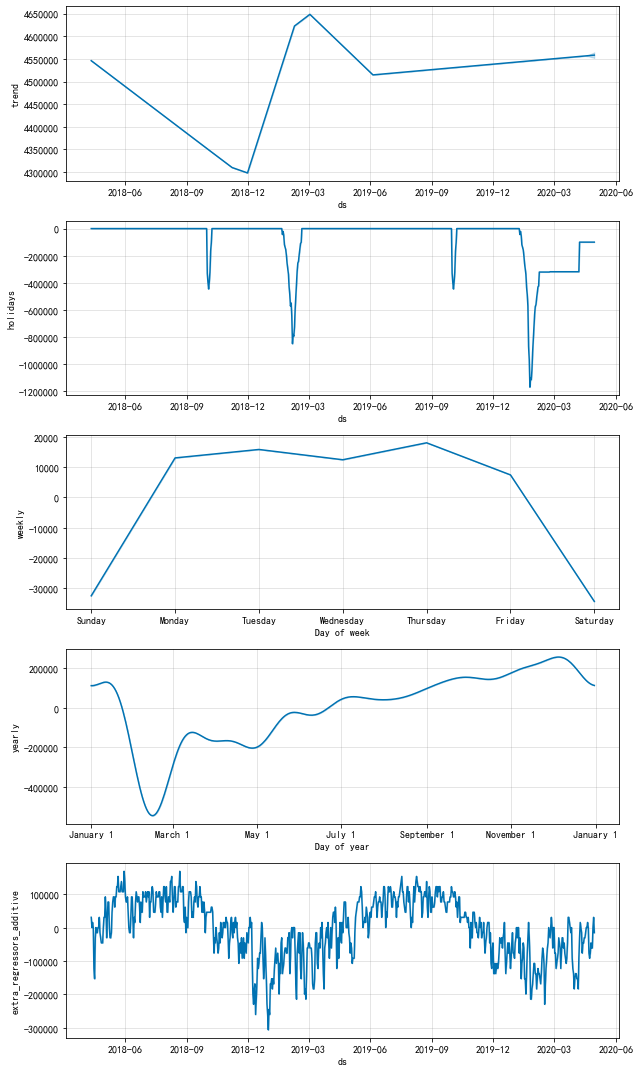

In [64]:
m.plot_components(forecast)

In [ ]:
# #交叉验证
# from fbprophet.diagnostics import cross_validation
# from sklearn.metrics import mean_squared_error
# df_cv = cross_validation(m, initial='1095 days', period='7 days', horizon = '31 days')
# # df_cv[['yhat','yhat_lower','yhat_upper','y']] = np.exp(df_cv[['yhat','yhat_lower','yhat_upper','y']])

# def rmse(df):
#     return np.sqrt(mean_squared_error(df['y'],df['yhat']))

# df_cv.groupby('cutoff').apply(rmse).mean()

In [ ]:
# help(Prophet)

In [51]:
# m.changepoints_t

array([0.03616484, 0.07232969, 0.10765349, 0.14381833, 0.17998318,
       0.21614802, 0.25231287, 0.28763667, 0.32380151, 0.35996636,
       0.3961312 , 0.43229605, 0.46761985, 0.50378469, 0.53994954,
       0.57611438, 0.61227923, 0.64760303, 0.68376787, 0.71993272,
       0.75609756, 0.79226241, 0.82758621, 0.86375105, 0.8999159 ])

In [ ]:
# df_cv.query("cutoff ==  '2020-03-02'")

In [ ]:
# from fbprophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cv)
# df_p

In [60]:
future = m.make_future_dataframe(periods=21,freq = 'd',
                                 include_history = False)
future 

,ds
0,2020-04-10
1,2020-04-11
2,2020-04-12
3,2020-04-13
4,2020-04-14
5,2020-04-15
6,2020-04-16
7,2020-04-17
8,2020-04-18
9,2020-04-19


In [61]:
# future['cap'] = cap
future['最高温度'] = [27,26,22,24,24,
                      25,25,26,27,27,
                      28,27,22,21,22,
                      24,23,23,27,29,
                      26]
future = sup_water_train[['ds','最高温度']].append(future,ignore_index=True)

In [62]:
print(future)

            ds  最高温度
0   2018-04-11  29.0
1   2018-04-12  27.0
2   2018-04-13  28.0
3   2018-04-14  27.0
4   2018-04-15  19.0
..         ...   ...
746 2020-04-26  23.0
747 2020-04-27  23.0
748 2020-04-28  27.0
749 2020-04-29  29.0
750 2020-04-30  26.0

[751 rows x 2 columns]


In [63]:
forecast = m.predict(future)

In [65]:
forecast.tail(21)[['ds','yhat']]

,ds,yhat
730,2020-04-10,4.297560e+06
731,2020-04-11,4.240031e+06
732,2020-04-12,4.179617e+06
733,2020-04-13,4.254484e+06
734,2020-04-14,4.255574e+06
735,2020-04-15,4.265446e+06
736,2020-04-16,4.268592e+06
737,2020-04-17,4.270615e+06
738,2020-04-18,4.241280e+06
739,2020-04-19,4.240001e+06


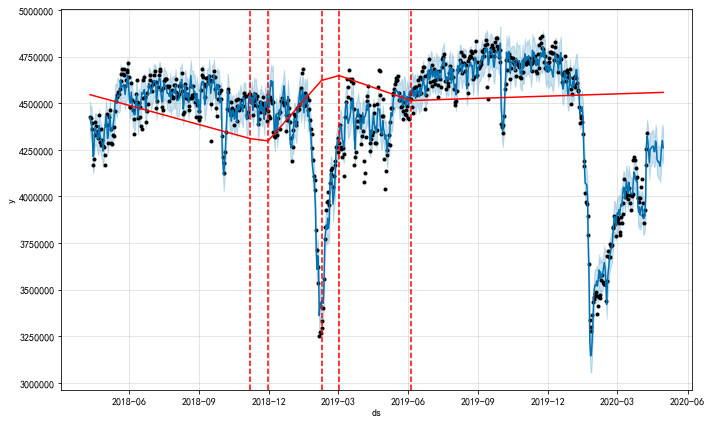

In [66]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)